In [2]:
''' 
We start by importing the necessary libraries and define the path to our data (cell images)

'''

import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

parasitized_path = 'cell_images/Parasitized/'
healthy_path = 'cell_images/Healthy/'


In [3]:
''' 
First step is to load our dataset. As we can see in our repo, we have 2 folders,
where one of them contains images of infected cells, and the other one, images of healthy cells. 

'''

def load_data_and_labels(folder_path, label):

    images = []
    labels = []

    for filename in os.listdir(folder_path):

        image = cv2.imread(os.path.join(folder_path,filename))

        if image is not None:
            image = cv2.resize(image, (64,64))
            images.append(image)
            labels.append(label)

    return images,labels

uninfected_images, uninfected_labels = load_data_and_labels(healthy_path,0)
parasitized_images, parasitized_labels = load_data_and_labels(parasitized_path,1)



X = np.array(uninfected_images + parasitized_images)
y = np.array(uninfected_labels + parasitized_labels)


'''
Scale our pixel values from 0-255 to 0-1

'''
X = X / 255.0
print(f'Original shape : {X.shape}')

''' 
Here we need to reshape each of our images that consitsts of 64 pixels height,
64 pixels width and 3 channels, to one flattened vector containing all the values,
which will be used as our input for our models. 

'''

n_samples, height, width, n_channels = X.shape
X = X.reshape(n_samples, -1)

print(f'Shape after reshaping : {X.shape}')


Original shape : (27556, 64, 64, 3)
Shape after reshaping : (27556, 12288)


In [103]:
''' 
Start building our custom logistic regression model. 

'''

def sigmoid(z):
    y = 1 / (1 + np.exp(-z))
    return y

def binary_cross_entropy(y_true,y_pred):
    ce = -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
    return ce

def accuracy(y_true,y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    acc = (correct / total) * 100

    return acc


def predict(X, W, b,threshold = .5):
    z = X.dot(W) + b
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    return probabilities, predictions


def train_logistic_regression(X_train,X_test,y_train,y_test,lr=0.001,epochs=10000):

    samples,features = X.shape

    W = np.zeros(features)
    b = 0

    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        
        '''For every weight and bias update, we predict again on our train and test data, to see how our
        loss and acuracy evolve over every epoch.'''

        y_train_pred_prob,y_train_pred = predict(X_train, W, b)
        y_test_pred_prob,y_test_pred = predict(X_test, W, b)

        # Calculate losses
        train_loss = binary_cross_entropy(y_train, y_train_pred_prob)
        test_loss = binary_cross_entropy(y_test, y_test_pred_prob)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_accuracy = accuracy(y_train,y_train_pred)
        test_accuracy = accuracy(y_test,y_test_pred)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}, Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')


        dW = ((y_train_pred_prob - y_train).dot(X_train)) / samples
        db = (np.sum(y_train_pred_prob - y_train)) / samples

        

        W -= lr * dW
        b -= lr * db

    return W,b,train_losses,test_losses,train_accuracies,test_accuracies

'''
Shuffle our sample because initally everyhting is in order and we do not want this as it can confuse our model.
'''
X, y = shuffle(X, y, random_state=42)

'''
Keep 20% of our data aside as a test dataset, which will be unseen by our model while training.
'''
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=101)

final_W, final_b, train_losses, test_losses,train_accuracies,test_accuracies = train_logistic_regression(X_train,X_test,y_train,y_test)

Epoch: 0, Train Loss: 0.69, Test Loss: 0.69, Train accuracy: 49.71, Test accuracy: 51.14
Epoch: 1000, Train Loss: 0.63, Test Loss: 0.63, Train accuracy: 65.34, Test accuracy: 65.24
Epoch: 2000, Train Loss: 0.62, Test Loss: 0.62, Train accuracy: 66.68, Test accuracy: 66.15
Epoch: 3000, Train Loss: 0.61, Test Loss: 0.61, Train accuracy: 67.10, Test accuracy: 66.71
Epoch: 4000, Train Loss: 0.61, Test Loss: 0.61, Train accuracy: 67.35, Test accuracy: 66.87
Epoch: 5000, Train Loss: 0.60, Test Loss: 0.61, Train accuracy: 67.59, Test accuracy: 67.16
Epoch: 6000, Train Loss: 0.60, Test Loss: 0.61, Train accuracy: 67.80, Test accuracy: 67.20
Epoch: 7000, Train Loss: 0.60, Test Loss: 0.61, Train accuracy: 68.01, Test accuracy: 67.33
Epoch: 8000, Train Loss: 0.60, Test Loss: 0.61, Train accuracy: 68.34, Test accuracy: 67.31
Epoch: 9000, Train Loss: 0.60, Test Loss: 0.60, Train accuracy: 68.49, Test accuracy: 67.63


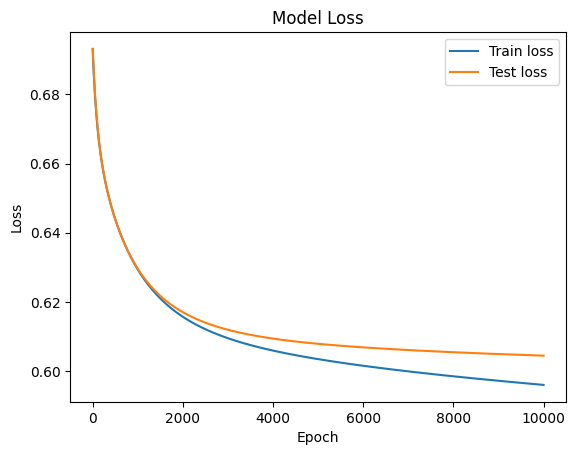

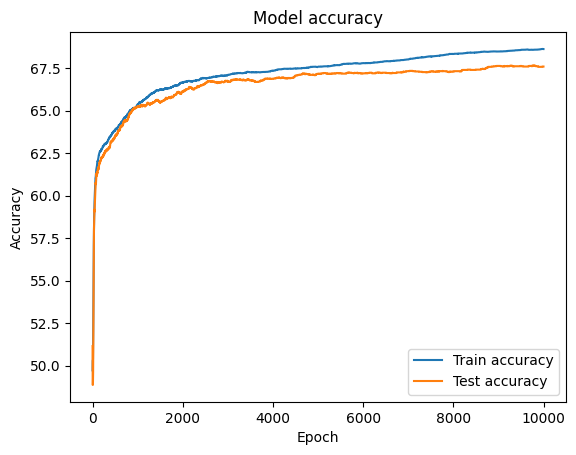

In [104]:
'''
Let's now plot how our loss and accuracy change over time as our models train,
and our weights and biases keep updating with gradient descent. 

'''


plt.plot(train_losses,label='Train loss')
plt.plot(test_losses,label='Test loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


plt.plot(train_accuracies,label='Train accuracy')
plt.plot(test_accuracies,label='Test accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [105]:
''' 
In this section, we will apply Scikit-Learn's Logistic Regression model to our data, in order to double check or make sure that we
are getting similar, of not the same Loss and Accuracy. This is a way to compare our custom model with a benchmarked,
and tested model, to make sure our custom model development was correct all the way. 

'''

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,log_loss

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(max_iter=10000)


model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

train_loss = log_loss(y_train, y_train_prob)
test_loss = log_loss(y_test, y_test_prob)


train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


print("Model Evaluation Metrics:")
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Train Log Loss: {train_loss:.2f}")
print(f"Test Log Loss: {test_loss:.2f}")




Model Evaluation Metrics:
Train Accuracy: 82.29%
Test Accuracy: 67.33%
Train Log Loss: 0.41
Test Log Loss: 0.70


In [106]:
''' 
Now we will focus on creating a Feed-Forward Neural Network (DNN) using TensorFlow/Keras. 

The architecture includes:

Input Layer: 
Accepts the flattened input features (scaled values of the images).

Hidden Layers:
Two hidden layers, each with ReLU (Rectified Linear Unit) activation, are used to introduce non-linearity into the model.
Dropout is applied after each layer to prevent overfitting by randomly setting a fraction of the neurons to zero during training.

Output Layer: 
A single neuron with a sigmoid activation function outputs the probability of the positive class (parasitized cell).

'''


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# Assume X and y are your dataset and labels
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the Feed-Forward Neural Network
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(.5),

    Dense(16, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, 
                    batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict probabilities and binary labels
y_pred_prob = model.predict(X_test)  # Probabilities
y_pred = (y_pred_prob >= 0.5).astype(int)  # Binary labels


/Users/ktsolakidis/miniconda3/envs/ML/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5519 - loss: 2.0311 - val_accuracy: 0.6089 - val_loss: 0.6625
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5714 - loss: 0.7214 - val_accuracy: 0.6602 - val_loss: 0.6455
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5950 - loss: 0.6755 - val_accuracy: 0.6709 - val_loss: 0.6369
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6050 - loss: 0.6506 - val_accuracy: 0.6791 - val_loss: 0.6208
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6301 - loss: 0.6368 - val_accuracy: 0.6762 - val_loss: 0.6147
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6474 - loss: 0.6287 - val_accuracy: 0.6811 - val_loss: 0.6021
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6395 - loss: 0.6241 - val_accuracy: 0.6742 - val_loss: 0.6030
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6466 - loss: 0.6186 - val_accu

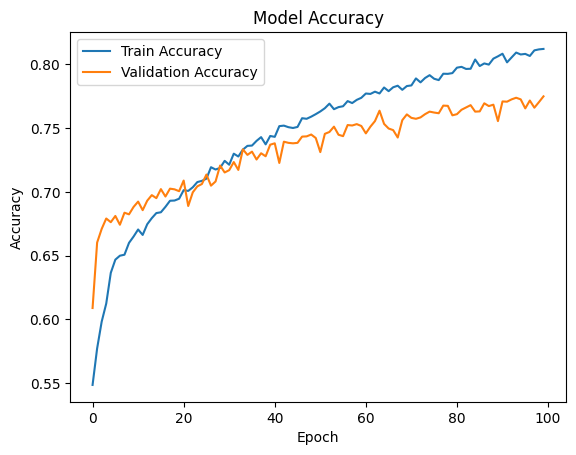

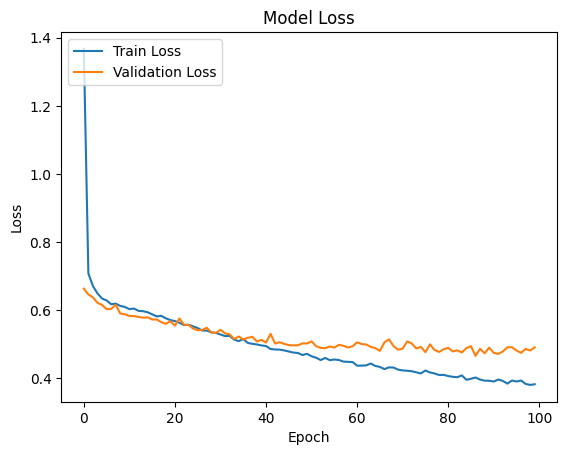

In [107]:
'''
Again we plot our Neural Netowork's train and test accuracy and loss.
As we can observe, the results are a bit better from our Logistic Regression models, but we are unable to 
observe and important improvement in accuracy and loss.

'''

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [4]:
'''
Before we start developing our Convolutional Neural Network, we need to reshape our input, 
as a CNN needs an image shaped input.
'''

X.shape
height = 64
width = 64
channels = 3
X = X.reshape(-1, height, width, channels)

print("Reshaped X:", X.shape)  # Output: (27556, 64, 64, 3)


Reshaped X: (27556, 64, 64, 3)


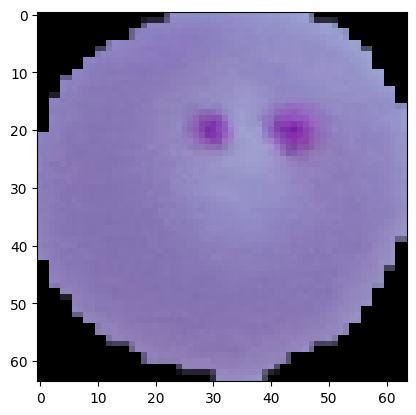

In [109]:
'''
Let's plot a random cell image just to be sure we have the correct format 
'''

plt.imshow(X[9,:,:,:])
plt.show()

In [110]:
'''
Now let's finally go to the last model we will test on our cell images dataset, 
which will be a Convolutional Neural Network.


The architecture includes:

Input Layer:
Accepts the input images with dimensions (64,64,3),representing the height, width, and RGB channels.

Convolutional Layers:
Two convolutional layers with ReLU (Rectified Linear Unit) activation extract spatial features from the images.
 L2 regularization is applied to reduce overfitting.

Pooling Layers:
MaxPooling layers follow each convolutional layer to down-sample the feature maps, 
reducing spatial dimensions and computational cost.

Dropout Layers:
Dropout is applied after each pooling layer to prevent overfitting by randomly setting a fraction of neurons to zero,
during training.

Fully Connected Layers:
The flattened feature maps are passed to a dense layer with 128 neurons and ReLU activation, 
followed by another dropout layer for regularization to prevent overfitting.

Output Layer:
A single neuron with a sigmoid activation function outputs the probability of the positive class (parasitized cell).

It is a simple CNN but we expect it to outperform our previous models.
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.02), input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.02)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")



/Users/ktsolakidis/miniconda3/envs/ML/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6264 - loss: 0.8818 - val_accuracy: 0.9111 - val_loss: 0.3638
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9000 - loss: 0.3610 - val_accuracy: 0.9207 - val_loss: 0.2793
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9153 - loss: 0.2841 - val_accuracy: 0.9167 - val_loss: 0.2540
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9176 - loss: 0.2558 - val_accuracy: 0.9048 - val_loss: 0.2504
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9272 - loss: 0.2480 - val_accuracy: 0.9289 - val_loss: 0.2355
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9305 - loss: 0.2504 - val_accuracy: 0.9376 - val_loss: 0.2299
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9363 - loss: 0.2244 - val_accuracy: 0.9401 - val_loss: 0.2230
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9353 - loss: 0.2267 - 

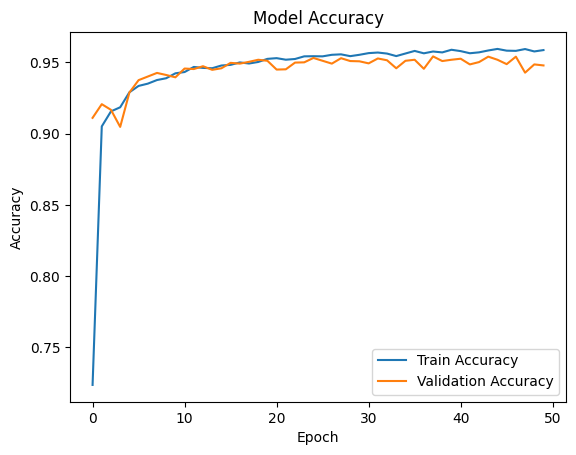

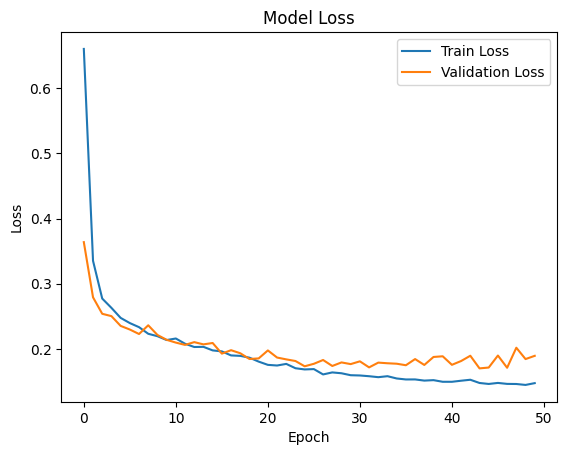

In [111]:
'''
We can now reallu see the difference. By plotting our changing
loss and accuracy, it is clear that a simple CNN, can outperform all the other 
models that we tested, when it comes to image classification!
'''


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
'''
In this final section, I will try to make my CNN even more accurate. 

I will add more layers, adjust my dropout and regularization, test different values,
and try to end up with a model almost close to perfect.

Changes compared to our last CNN model: 

1) Double first convolutional layer.
2) Added padding.
3) One more extra convolutional layer + one more pooling layer.
4) 256 neurons in the Dense layer instead of 128.
5) Added ReduceLROnPlateau which adjusts the learning rate dynamically
'''


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
cnn_model = Sequential([

    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5),


    Dense(1, activation='sigmoid')
])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=50,
                        batch_size=32,
                        callbacks=[reduce_lr])

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.5447 - loss: 1.1279 - val_accuracy: 0.9380 - val_loss: 0.2653 - learning_rate: 0.0010
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9327 - loss: 0.2891 - val_accuracy: 0.9568 - val_loss: 0.2393 - learning_rate: 0.0010
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.9483 - loss: 0.2577 - val_accuracy: 0.9530 - val_loss: 0.2403 - learning_rate: 0.0010
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9520 - loss: 0.2487 - val_accuracy: 0.9581 - val_loss: 0.1993 - learning_rate: 0.0010
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.9520 - loss: 0.2367 - val_accuracy: 0.9557 - val_loss: 0.2150 - learning_rate: 0.0010
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9507 - loss: 0.2388 - val_accuracy: 0.9536 - val_loss: 0.2204 - learning_rate: 0.0010
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9544 - l

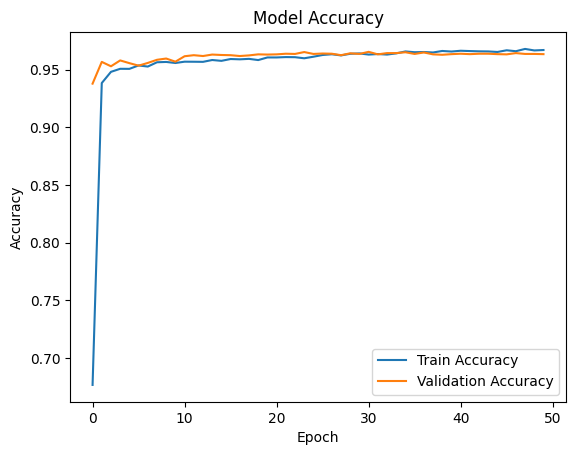

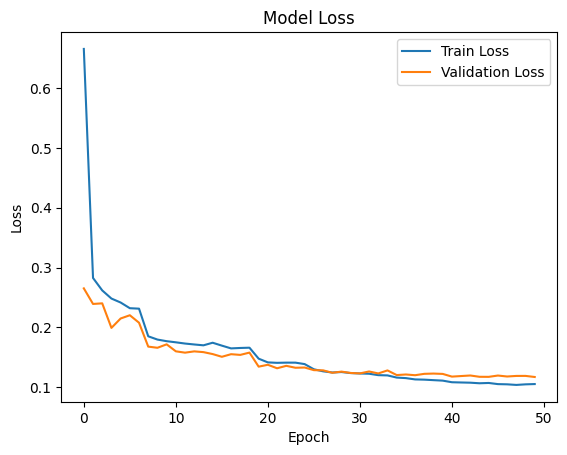

In [40]:
'''
Making tha chages/ modifications that we previously mentioned, we are now able to get a model,
with an accuracy more than 96%!
'''

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()